# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm  
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from skrebate import ReliefF
import warnings
from termcolor import colored
warnings.filterwarnings("ignore")
sns.set()

# Functions

In [2]:
def draw_pie(dataset,column,title):
    dataset.plot.pie(y=column,figsize=(10,7),autopct='%1.1f%%', startangle=-90)
    plt.legend(loc="upper right", fontsize=12)
    plt.title(title,fontsize=16)
    plt.show()

In [3]:
def divide (dataset_healthy, dataset_unhealthy):
    size_train_h=int(dataset_healthy.shape[0]*0.7)
    size_train_u=int(dataset_unhealthy.shape[0]*0.7)
    print('size_train : ',size_train_h+size_train_u , '(',round(100*(size_train_h+size_train_u)/(dataset_healthy.shape[0]+dataset_unhealthy.shape[0]),3),'%)')
    
          
    size_val_h=int(dataset_healthy.shape[0]*0.15)
    size_val_u=int(dataset_unhealthy.shape[0]*0.15)
    print('size_train : ',size_val_h+size_val_u , '(',round(100*(size_val_h+size_val_u)/(dataset_healthy.shape[0]+dataset_unhealthy.shape[0]),3),'%)')
    
          
    size_test_h=dataset_healthy.shape[0]-size_val_h-size_train_h
    size_test_u=dataset_unhealthy.shape[0]-size_val_u-size_train_u
    print('size_test : ',size_test_h+size_test_u, '(',round(100*(size_test_h+size_test_u)/(dataset_healthy.shape[0]+dataset_unhealthy.shape[0]),3),'%)')
    
    train = pd.concat([dataset_healthy[0:size_train_h],dataset_unhealthy[0:size_train_u]])
    val=pd.concat([dataset_healthy[size_train_h:size_train_h+size_val_h],dataset_unhealthy[size_train_u:size_train_u+size_val_u]])
    test=pd.concat([dataset_healthy[size_train_h+size_val_h:],dataset_unhealthy[size_train_u+size_val_u:]])
    
    train = shuffling(train)
    val = shuffling(val)
    test =  shuffling(test)
    
    return train , val , test

In [4]:
def divide1 (dataset,y):
    Y=dataset['class'] 
    X=dataset.drop(columns=['class'])
    
    X_scored = ReliefF(n_features_to_select=7, n_neighbors=y).fit(np.array(X) , np.array(Y))
    
    feature_scoring = pd.DataFrame({
        'feature': X.columns,
        'score': X_scored.feature_importances_
    })
    
    scores=feature_scoring.sort_values('score', ascending=True)
    y_pos = np.arange(1, len(scores.score) + 1)
    plt.figure(figsize=(15,5))
    plt.barh(y_pos, scores.score, align='center' )
    plt.yticks(y_pos, scores['feature'],fontsize=12)
    plt.xlabel('Importance',fontsize=16)
    plt.title('Feature Importance Plot',fontsize=16)
    plt.show()

    val=list(feature_scoring.loc[feature_scoring.score > (max(feature_scoring.score)/2)]['feature'])

    X=X[val]
    return X,Y,val

In [5]:
def divide2(dataset,val):
    Y=dataset['class'] 
    X=dataset.drop(columns=['class'])
    X=X[val]
    return X,Y

In [6]:
def shuffling(data):
    np.random.seed(30)
    df2 = data.reindex(np.random.permutation(data.index))
    return(df2)

In [7]:
def performance(Y_t,Y_p):
    f1=f1_score(Y_t, Y_p) 
    auc=roc_auc_score(Y_t, Y_p)
    precision=precision_score(Y_t, Y_p)
    recall=recall_score(Y_t, Y_p)
    acc=accuracy_score(Y_t, Y_p)

    print('f1_score : ',round(f1,3))
    print('accuracy : ',round(acc,3))
    print('auc : ',round(auc,3))
    print('precision : ',round(precision,3))
    print('recall : ', round(recall,3))
    
    # Confusion Matrix : 0 for healthy and 1 for unhealthy
    sns.set(font_scale = 1.1)
    plt.figure(figsize = (7 , 5))
    c_m=(100*confusion_matrix(Y_t, Y_p ,normalize='true')).round(2)
    #c_m2=(confusion_matrix(Y_test2, Y_pred2 ))
    sns.heatmap(c_m, fmt='g',cmap = "Blues", annot = True, linewidths = 0.5 , cbar = False)
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.title('Confusion Matrix (%)')
    plt.show()

In [8]:
def model (dict):
    if dict['kernel'] == 'linear':
        clf = svm.SVC(C= dict['C'], kernel= 'linear')
    else:
        clf = svm.SVC(C= dict['C'], kernel= dict['kernel'],gamma=dict['gamma'])
    return clf

In [9]:
def model1 (dict):
    if dict['kernel'] == 'linear':
        clf = svm.SVC(C= dict['C'], kernel= 'linear',class_weight='balanced')
    else:
        clf = svm.SVC(C= dict['C'], kernel= dict['kernel'],gamma=dict['gamma'],class_weight='balanced')
    return clf

In [10]:
def model2 (dict,im,m):  
    if im : 
        if dict['kernel'] == 'linear':
            clf = svm.SVC(C= dict['C'], kernel= 'linear',class_weight='balanced',decision_function_shape=m)
        else:
            clf = svm.SVC(C= dict['C'], kernel= dict['kernel'],gamma=dict['gamma'],class_weight='balanced',decision_function_shape=m)    
    else : 
        if dict['kernel'] == 'linear':
            clf = svm.SVC(C= dict['C'], kernel= 'linear',decision_function_shape=m)
        else:
            clf = svm.SVC(C= dict['C'], kernel= dict['kernel'],gamma=dict['gamma'],decision_function_shape=m)    
    
    return clf

In [11]:
def cross_val(healthy,unhealthy,param,im,val):
    size_F=healthy.shape[0]//5
    size_F1=unhealthy.shape[0]//5
    
    f1=[]
    auc=[]
    precision=[]
    recall=[]
    acc=[]
    c_m=np.zeros((2,2))
    d={}
    d1={}
    
    if im:
        clf1 = model1(param)
    else:
        clf1 = model(param)

    d['H_1']=healthy[0:size_F]
    d['H_2']=healthy[size_F:2*size_F]
    d['H_3']=healthy[2*size_F:3*size_F]
    d['H_4']=healthy[3*size_F:4*size_F]
    d['H_5']=healthy[4*size_F:]
    d1['U_1']=unhealthy[0:size_F1]
    d1['U_2']=unhealthy[size_F1:2*size_F1]
    d1['U_3']=unhealthy[2*size_F1:3*size_F1]
    d1['U_4']=unhealthy[3*size_F1:4*size_F1]
    d1['U_5']=unhealthy[4*size_F1:]

    for i in range (1,6):
        test = shuffling (pd.concat([d['H_'+str(i)],d1['U_'+str(i)]]))
        data1=pd.DataFrame()
        data2=pd.DataFrame()
        for j in range(1,6):
            if j!=i:
                data1=pd.concat([data1,d['H_'+str(j)]])
                data2=pd.concat([data2,d1['U_'+str(j)]])
        train=pd.concat([data1,data2])
        train=shuffling(train)

        if i == 1:
            print('the 4 first data')
            print('size_train : ',train.shape[0] , '(',round(100*train.shape[0]/(train.shape[0]+test.shape[0]),3),'%)')
            print('size_test : ',test.shape[0], '(',round(100*test.shape[0]/(train.shape[0]+test.shape[0]),3),'%)')    
            draw_pie(pd.DataFrame(train.diagnosis.value_counts()),'diagnosis','train')
            draw_pie(pd.DataFrame(test.diagnosis.value_counts()),'diagnosis','test')
        if i == 5:
            print('the final')
            print('size_train : ',train.shape[0] , '(',round(100*train.shape[0]/(train.shape[0]+test.shape[0]),3),'%)')
            print('size_test : ',test.shape[0], '(',round(100*test.shape[0]/(train.shape[0]+test.shape[0]),3),'%)')    
            draw_pie(pd.DataFrame(train.diagnosis.value_counts()),'diagnosis','train')
            draw_pie(pd.DataFrame(test.diagnosis.value_counts()),'diagnosis','test')

        X_train,Y_train = divide2(train[['Ramp', 'Rper', 'Roq_r', 'OQ_r', 'Roq_l', 'OQ_l', 'PSI','GGI_r','GGI_l','ALR_r','ALR_l','C_r','C_l','ST_r','ST_l','class']],val)
        X_test,Y_test = divide2(test[['Ramp', 'Rper', 'Roq_r', 'OQ_r', 'Roq_l', 'OQ_l', 'PSI','GGI_r','GGI_l','ALR_r','ALR_l','C_r','C_l','ST_r','ST_l','class']],val)
        
        scaler = StandardScaler()
        X_train_std = scaler.fit_transform(X_train)
        X_test_std = scaler.transform(X_test)
        clf1.fit(X_train_std,Y_train)

        # Make prediction 

        Y_pred = clf1.predict(X_test_std)
        f1.append(f1_score(Y_test, Y_pred))
        auc.append(roc_auc_score(Y_test, Y_pred))
        precision.append(precision_score(Y_test, Y_pred))
        recall.append(recall_score(Y_test, Y_pred))
        acc.append(accuracy_score(Y_test, Y_pred))
        c_m=c_m+confusion_matrix(Y_test, Y_pred ,normalize='true')

    print('f1_score : ',round(np.mean(f1),3))
    print('accuracy : ',round(np.mean(acc),3))
    print('auc : ',round(np.mean(auc),3))
    print('precision : ',round(np.mean(precision),3))
    print('recall : ', round(np.mean(recall),3))
    c_m=100*c_m/5
    sns.set(font_scale = 1.1)
    plt.figure(figsize = (7 , 5))
    sns.heatmap(c_m, fmt='.2f',cmap = "Blues", annot = True, linewidths = 0.5 , cbar = False)
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.title('Confusion Matrix (%)')
    plt.show()


In [12]:
def cross_val1(healthy,unhealthy,param,im,m,val):
    size_F=healthy.shape[0]//5
    size_F1=unhealthy.shape[0]//5
    
    c_m=np.zeros((5,5))
    d={}
    d1={}
    
    
    if m != False :
        clf=model2(param,im,m)
    else:
        if im :
            clf = model1(param) 
        else:
            clf = model(param)

    d['H_1']=healthy[0:size_F]
    d['H_2']=healthy[size_F:2*size_F]
    d['H_3']=healthy[2*size_F:3*size_F]
    d['H_4']=healthy[3*size_F:4*size_F]
    d['H_5']=healthy[4*size_F:]
    d1['U_1']=unhealthy[0:size_F1]
    d1['U_2']=unhealthy[size_F1:2*size_F1]
    d1['U_3']=unhealthy[2*size_F1:3*size_F1]
    d1['U_4']=unhealthy[3*size_F1:4*size_F1]
    d1['U_5']=unhealthy[4*size_F1:]

    for i in range (1,6):
        test = shuffling (pd.concat([d['H_'+str(i)],d1['U_'+str(i)]]))
        data1=pd.DataFrame()
        data2=pd.DataFrame()
        for j in range(1,6):
            if j!=i:
                data1=pd.concat([data1,d['H_'+str(j)]])
                data2=pd.concat([data2,d1['U_'+str(j)]])
        train=pd.concat([data1,data2])
        train=shuffling(train)

        if i == 1:
            print('the 4 first data')
            print('size_train : ',train.shape[0] , '(',round(100*train.shape[0]/(train.shape[0]+test.shape[0]),3),'%)')
            print('size_test : ',test.shape[0], '(',round(100*test.shape[0]/(train.shape[0]+test.shape[0]),3),'%)')    
            draw_pie(pd.DataFrame(train.diagnosis.value_counts()),'diagnosis','train')
            draw_pie(pd.DataFrame(test.diagnosis.value_counts()),'diagnosis','test')
        if i == 5:
            print('the final')
            print('size_train : ',train.shape[0] , '(',round(100*train.shape[0]/(train.shape[0]+test.shape[0]),3),'%)')
            print('size_test : ',test.shape[0], '(',round(100*test.shape[0]/(train.shape[0]+test.shape[0]),3),'%)')    
            draw_pie(pd.DataFrame(train.diagnosis.value_counts()),'diagnosis','train')
            draw_pie(pd.DataFrame(test.diagnosis.value_counts()),'diagnosis','test')

        X_train,Y_train = divide2(train[['Ramp', 'Rper', 'Roq_r', 'OQ_r', 'Roq_l', 'OQ_l', 'PSI','GGI_r','GGI_l','ALR_r','ALR_l','C_r','C_l','ST_r','ST_l','class']],val)
        X_test,Y_test = divide2(test[['Ramp', 'Rper', 'Roq_r', 'OQ_r', 'Roq_l', 'OQ_l', 'PSI','GGI_r','GGI_l','ALR_r','ALR_l','C_r','C_l','ST_r','ST_l','class']],val)
        
        scaler = StandardScaler()
        X_train_std = scaler.fit_transform(X_train)
        X_test_std = scaler.transform(X_test)
        clf.fit(X_train_std,Y_train)
        Y_pred = clf.predict(X_test_std)
        # Make prediction 
        c_m=c_m+confusion_matrix(Y_test, Y_pred ,normalize='true')

    c_m=100*c_m/5
    sns.set(font_scale = 1.1)
    plt.figure(figsize = (7 , 5))
    sns.heatmap(c_m,cmap = "Blues", annot = True, linewidths = 0.5 , cbar = False , fmt ='.2f')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.title('Confusion Matrix (%)')
    plt.show()


In [13]:
def cross_val2(healthy,unhealthy,param,im,m,c,method,val):
    size_F=healthy.shape[0]//5
    size_F1=unhealthy.shape[0]//5
    
    c_m=np.zeros((5,5))
    d={}
    d1={}
    
    
    if m != False :
        clf=model2(param,im,m)
    else:
        if im :
            clf = model1(param) 
        else:
            clf = model(param)
    clf_cv = CalibratedClassifierCV(clf, cv=c, method=method)

    d['H_1']=healthy[0:size_F]
    d['H_2']=healthy[size_F:2*size_F]
    d['H_3']=healthy[2*size_F:3*size_F]
    d['H_4']=healthy[3*size_F:4*size_F]
    d['H_5']=healthy[4*size_F:]
    d1['U_1']=unhealthy[0:size_F1]
    d1['U_2']=unhealthy[size_F1:2*size_F1]
    d1['U_3']=unhealthy[2*size_F1:3*size_F1]
    d1['U_4']=unhealthy[3*size_F1:4*size_F1]
    d1['U_5']=unhealthy[4*size_F1:]

    for i in range (1,6):
        test = shuffling (pd.concat([d['H_'+str(i)],d1['U_'+str(i)]]))
        data1=pd.DataFrame()
        data2=pd.DataFrame()
        for j in range(1,6):
            if j!=i:
                data1=pd.concat([data1,d['H_'+str(j)]])
                data2=pd.concat([data2,d1['U_'+str(j)]])
        train=pd.concat([data1,data2])
        train=shuffling(train)

        if i == 1:
            print('the 4 first data')
            print('size_train : ',train.shape[0] , '(',round(100*train.shape[0]/(train.shape[0]+test.shape[0]),3),'%)')
            print('size_test : ',test.shape[0], '(',round(100*test.shape[0]/(train.shape[0]+test.shape[0]),3),'%)')    
            draw_pie(pd.DataFrame(train.diagnosis.value_counts()),'diagnosis','train')
            draw_pie(pd.DataFrame(test.diagnosis.value_counts()),'diagnosis','test')
        if i == 5:
            print('the final')
            print('size_train : ',train.shape[0] , '(',round(100*train.shape[0]/(train.shape[0]+test.shape[0]),3),'%)')
            print('size_test : ',test.shape[0], '(',round(100*test.shape[0]/(train.shape[0]+test.shape[0]),3),'%)')    
            draw_pie(pd.DataFrame(train.diagnosis.value_counts()),'diagnosis','train')
            draw_pie(pd.DataFrame(test.diagnosis.value_counts()),'diagnosis','test')
            
        X_train,Y_train= divide2(train[['Ramp', 'Rper', 'Roq_r', 'OQ_r', 'Roq_l', 'OQ_l', 'PSI','GGI_r','GGI_l','ALR_r','ALR_l','C_r','C_l','ST_r','ST_l','class']],val)
        X_test,Y_test = divide2(test[['Ramp', 'Rper', 'Roq_r', 'OQ_r', 'Roq_l', 'OQ_l', 'PSI','GGI_r','GGI_l','ALR_r','ALR_l','C_r','C_l','ST_r','ST_l','class']],val)

        scaler = StandardScaler()
        X_train_std = scaler.fit_transform(X_train)
        X_test_std = scaler.transform(X_test)
        clf_cv.fit(X_train_std,Y_train)
        Y_pred = clf_cv.predict(X_test_std)

        # Make prediction 
        c_m=c_m+confusion_matrix(Y_test, Y_pred ,normalize='true')

    c_m=100*c_m/5
    sns.set(font_scale = 1.1)
    plt.figure(figsize = (7 , 5))
    sns.heatmap(c_m, fmt='.2f',cmap = "Blues", annot = True, linewidths = 0.5 , cbar = False)
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.title('Confusion Matrix (%)')
    plt.show()


In [14]:
def modeling (train,val,test,im,y):
    draw_pie(pd.DataFrame(train.diagnosis.value_counts()),'diagnosis','train')
    draw_pie(pd.DataFrame(val.diagnosis.value_counts()),'diagnosis','val')
    draw_pie(pd.DataFrame(test.diagnosis.value_counts()),'diagnosis','test')
    
    X_train,Y_train,F = divide1(train[['Ramp', 'Rper', 'Roq_r', 'OQ_r', 'Roq_l', 'OQ_l', 'PSI','GGI_r','GGI_l','ALR_r','ALR_l','C_r','C_l','ST_r','ST_l','class']],y)
    X_test,Y_test = divide2(test[['Ramp', 'Rper', 'Roq_r', 'OQ_r', 'Roq_l', 'OQ_l', 'PSI','GGI_r','GGI_l','ALR_r','ALR_l','C_r','C_l','ST_r','ST_l','class']],F)
    X_val,Y_val = divide2(val[['Ramp', 'Rper', 'Roq_r', 'OQ_r', 'Roq_l', 'OQ_l', 'PSI','GGI_r','GGI_l','ALR_r','ALR_l','C_r','C_l','ST_r','ST_l','class']],F)
    
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    X_val_std = scaler.transform(X_val)
    
    param_grid = [
              {'kernel': ['linear'], 'C': [0.0001,0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
              {'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],'C': [0.0001,0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
              {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],'C': [0.0001,0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}
              ]
    
    if im :
        clf=svm.SVC(class_weight='balanced')
        
    else : 
        clf = svm.SVC()
        
    search = GridSearchCV(clf, param_grid, cv=5)
    search.fit(X_val_std,Y_val)
    print(search.best_params_)
    
    if im :
        clf = model1(search.best_params_) 
    else:
        clf = model(search.best_params_)
        
    clf.fit(X_train_std,Y_train)
    # Make prediction
    Y_pred = clf.predict(X_test_std)
    performance(Y_test,Y_pred)
    return(search.best_params_,F)


In [15]:
def modeling1 (train,val,test,im,m,y):
    draw_pie(pd.DataFrame(train.diagnosis.value_counts()),'diagnosis','train')
    draw_pie(pd.DataFrame(val.diagnosis.value_counts()),'diagnosis','val')
    draw_pie(pd.DataFrame(test.diagnosis.value_counts()),'diagnosis','test')
    
    X_train,Y_train,F = divide1(train[['Ramp', 'Rper', 'Roq_r', 'OQ_r', 'Roq_l', 'OQ_l', 'PSI','GGI_r','GGI_l','ALR_r','ALR_l','C_r','C_l','ST_r','ST_l','class']],y)
    X_test,Y_test = divide2(test[['Ramp', 'Rper', 'Roq_r', 'OQ_r', 'Roq_l', 'OQ_l', 'PSI','GGI_r','GGI_l','ALR_r','ALR_l','C_r','C_l','ST_r','ST_l','class']],F)
    X_val,Y_val = divide2(val[['Ramp', 'Rper', 'Roq_r', 'OQ_r', 'Roq_l', 'OQ_l', 'PSI','GGI_r','GGI_l','ALR_r','ALR_l','C_r','C_l','ST_r','ST_l','class']],F)
    
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    X_val_std = scaler.transform(X_val)
    
    param_grid = [
              {'kernel': ['linear'], 'C': [0.0001,0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
              {'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],'C': [0.0001,0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
              {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],'C': [0.0001,0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}
              ]
    
    if m != False :
        if im :
            clf=svm.SVC(class_weight='balanced',decision_function_shape=m)
        else : 
            clf=svm.SVC(decision_function_shape=m)
    else :
        if im : 
            clf=svm.SVC(class_weight='balanced')
        else : 
            clf = svm.SVC()
        
    search = GridSearchCV(clf, param_grid, cv=5)
    search.fit(X_val_std,Y_val)
    #print(search.best_params_)
    
    if m != False :
        clf=model2(search.best_params_,im,m)
        
    else: 
        if im :
            clf = model1(search.best_params_) 
        else:
            clf = model(search.best_params_)
        
    t=clf.fit(X_train_std,Y_train)
    print('Model :',t)
    # Make prediction
    Y_pred = clf.predict(X_test_std)
    
    # Confusion Matrix : 0 for healthy and 1 for unhealthy
    sns.set(font_scale = 1.1)
    plt.figure(figsize = (7 , 5))
    c_m=(100*confusion_matrix(Y_test, Y_pred ,normalize='true')).round(2)
    sns.heatmap(c_m, fmt='g',cmap = "Blues", annot = True, linewidths = 0.5 , cbar = False)
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.title('Confusion Matrix (%)')
    plt.show()
    
    return(search.best_params_,F)

In [16]:
def modeling2 (train,val,test,im,m,c,method,y):
    draw_pie(pd.DataFrame(train.diagnosis.value_counts()),'diagnosis','train')
    draw_pie(pd.DataFrame(val.diagnosis.value_counts()),'diagnosis','val')
    draw_pie(pd.DataFrame(test.diagnosis.value_counts()),'diagnosis','test')
    
    X_train,Y_train,F = divide1(train[['Ramp', 'Rper', 'Roq_r', 'OQ_r', 'Roq_l', 'OQ_l', 'PSI','GGI_r','GGI_l','ALR_r','ALR_l','C_r','C_l','ST_r','ST_l','class']],y)
    X_test,Y_test = divide2(test[['Ramp', 'Rper', 'Roq_r', 'OQ_r', 'Roq_l', 'OQ_l', 'PSI','GGI_r','GGI_l','ALR_r','ALR_l','C_r','C_l','ST_r','ST_l','class']],F)
    X_val,Y_val = divide2(val[['Ramp', 'Rper', 'Roq_r', 'OQ_r', 'Roq_l', 'OQ_l', 'PSI','GGI_r','GGI_l','ALR_r','ALR_l','C_r','C_l','ST_r','ST_l','class']],F)
    
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    X_val_std = scaler.transform(X_val)
    
    param_grid = [
              {'kernel': ['linear'], 'C': [0.0001,0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
              {'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],'C': [0.0001,0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
              {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],'C': [0.0001,0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}
              ]
    
    if m != False :
        if im :
            clf=svm.SVC(class_weight='balanced',decision_function_shape=m)
        else : 
            clf=svm.SVC(decision_function_shape=m)
    else :
        if im : 
            clf=svm.SVC(class_weight='balanced')
        else : 
            clf = svm.SVC()
        
    search = GridSearchCV(clf, param_grid, cv=5)
    search.fit(X_val_std,Y_val)
    #print(search.best_params_)
    
    if m != False :
        clf=model2(search.best_params_,im,m)
        
    else: 
        if im :
            clf = model1(search.best_params_) 
        else:
            clf = model(search.best_params_)
            
    clf_cv = CalibratedClassifierCV(clf, cv=c, method=method)
        
    t=clf_cv.fit(X_train_std,Y_train)
    print('Model :',t)
    # Make prediction
    Y_pred = clf_cv.predict(X_test_std)
    
    # Confusion Matrix : 0 for healthy and 1 for unhealthy
    sns.set(font_scale = 1.1)
    plt.figure(figsize = (7 , 5))
    c_m=(100*confusion_matrix(Y_test, Y_pred ,normalize='true')).round(2)
    sns.heatmap(c_m, fmt='g',cmap = "Blues", annot = True, linewidths = 0.5 , cbar = False)
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.title('Confusion Matrix (%)')
    plt.show()
    
    return(search.best_params_,F)

# All data

In [17]:
# Data of cycles

df = pd.read_excel ('C:/Users/USER/Desktop/stage ing/stage ing partie 3/INFO_subjects_out.xlsx',index=None)
df.set_index(['ID_P','ID_Cy'],inplace=True)
data=df.loc[df.state==1]

In [18]:
# Data of ratios

df1 = pd.read_csv("C:/Users/USER/Desktop/stage ing/stage ing partie 5/ratios.csv",sep=",",header=None)

# Rename the columns

df1.rename(columns={0:'Ramp', 1:'Rper', 2:'Roq_r',3: 'OQ_r',4: 'Roq_l', 5:'OQ_l', 6:'PSI',7:'GGI_r',8:'GGI_l',9:'ALR_r',10:'ALR_l',11:'C_r',12:'C_l',13:'ST_r',14:'ST_l'},inplace=True) 

# Re-index the data

df1=df1.set_index(data.index)

# Concatenate the two datasets

new_dd = pd.concat([data,df1],axis=1)

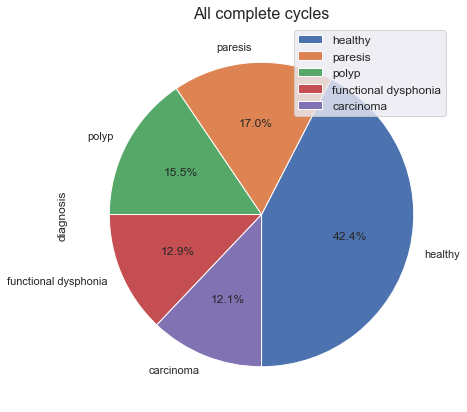

In [19]:
draw_pie(pd.DataFrame(data.diagnosis.value_counts()),'diagnosis','All complete cycles')

# Part 1 

In [20]:
healthy = new_dd.loc[new_dd.diagnosis=='healthy']
paresis= new_dd.loc[new_dd.diagnosis=='paresis']
polyp = new_dd.loc[new_dd.diagnosis=='polyp']
fun = new_dd.loc[new_dd.diagnosis=='functional dysphonia']
carcinoma =  new_dd.loc[new_dd.diagnosis=='carcinoma']
unhealthy = pd.concat([paresis[0:77],polyp[0:77],fun[0:77],carcinoma[0:78]],axis=0)

In [21]:
healthy['class']=0
unhealthy['class']=1
unhealthy = shuffling (unhealthy)

In [22]:
train , val , test  = divide (healthy,unhealthy)

size_train :  432 ( 69.903 %)
size_train :  92 ( 14.887 %)
size_test :  94 ( 15.21 %)


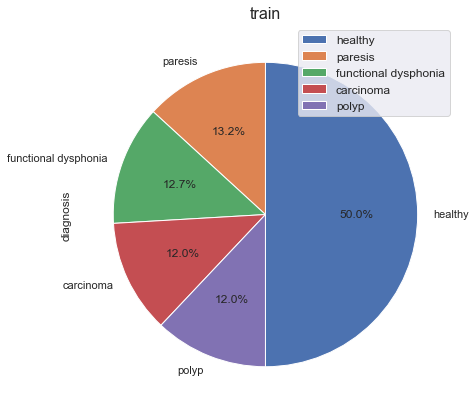

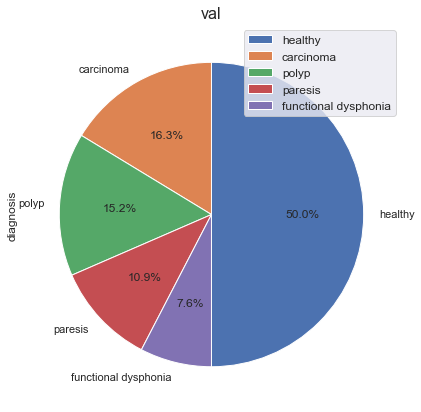

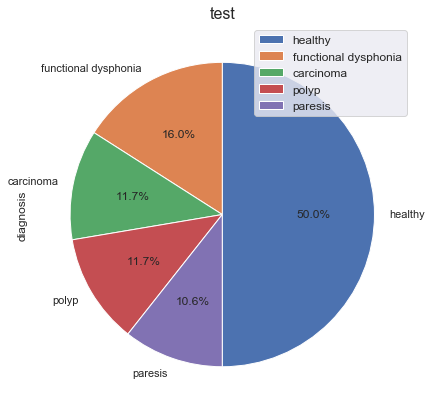

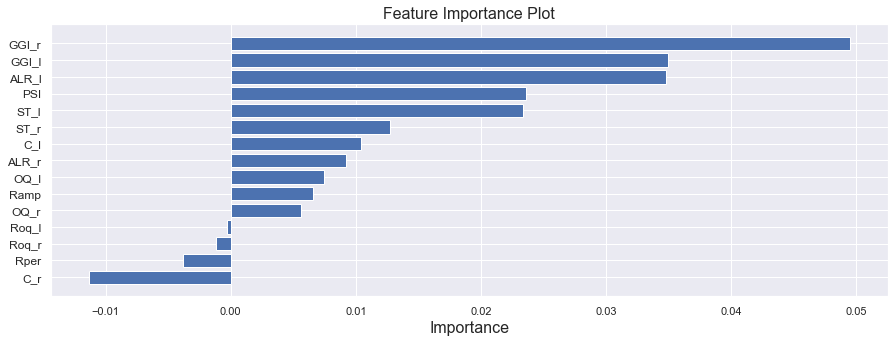

{'C': 50, 'gamma': 0.01, 'kernel': 'rbf'}
f1_score :  0.541
accuracy :  0.457
auc :  0.457
precision :  0.469
recall :  0.638


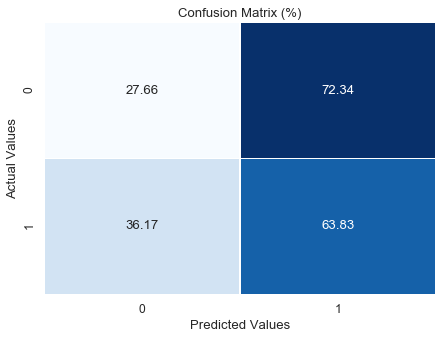

In [23]:
param,F =modeling(train , val , test , im=False,y=20)

In [24]:
print (F)

['GGI_r', 'GGI_l', 'ALR_l']


# Part 2 

the 4 first data
size_train :  496 ( 80.259 %)
size_test :  122 ( 19.741 %)


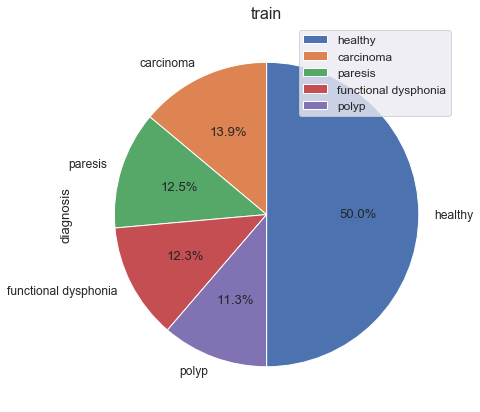

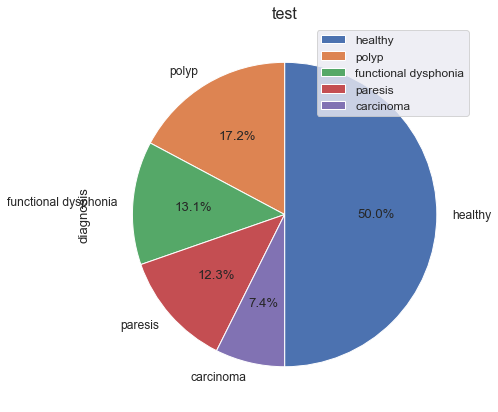

the final
size_train :  488 ( 78.964 %)
size_test :  130 ( 21.036 %)


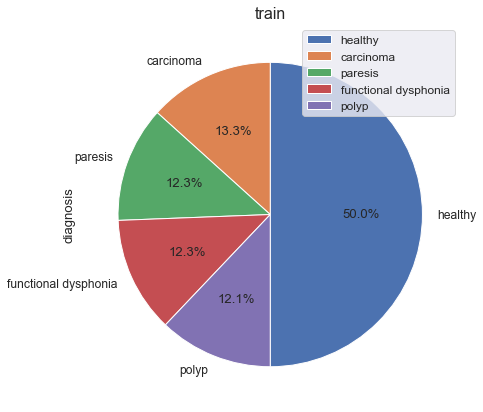

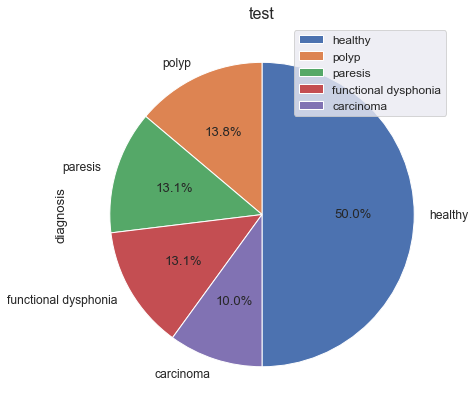

f1_score :  0.532
accuracy :  0.51
auc :  0.51
precision :  0.518
recall :  0.565


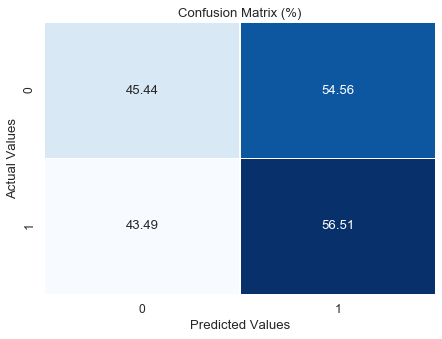

In [25]:
cross_val(healthy,unhealthy,param,False, F)

# Part 3 

In [26]:
data_imb = new_dd
data_imb['class']=0
data_imb.loc[data_imb.diagnosis!='healthy','class']=1
data_imb=shuffling(data_imb)

In [27]:
size_train=int(data_imb.shape[0]*0.7)
print('size_train : ',size_train , '(',round(100*size_train/data_imb.shape[0],3),'%)')
size_val=int(data_imb.shape[0]*0.15)
print('size_val : ',size_val, '(',round(100*size_val/data_imb.shape[0],3),'%)')
size_test=data_imb.shape[0]-size_val-size_train
print('size_test : ',size_test, '(',round(100*size_test/data_imb.shape[0],3),'%)')
    
train1 =data_imb[0:size_train]
val1=data_imb[size_train:size_train+size_val]
test1=data_imb[size_train+size_val:]

size_train :  509 ( 69.918 %)
size_val :  109 ( 14.973 %)
size_test :  110 ( 15.11 %)


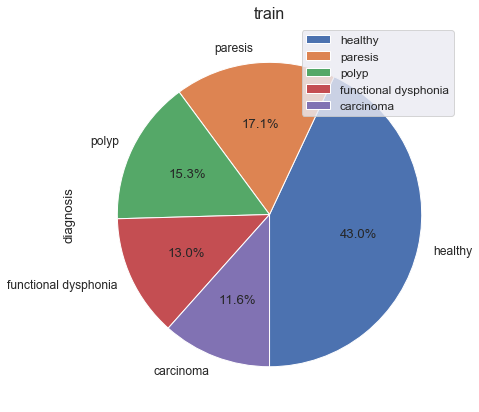

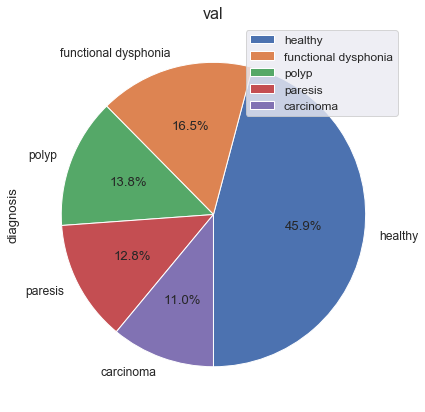

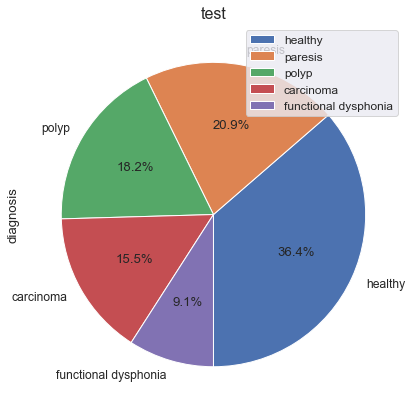

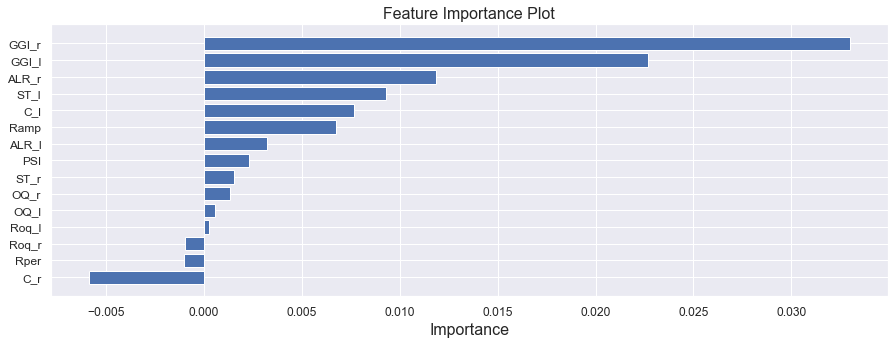

{'C': 0.001, 'kernel': 'linear'}
f1_score :  0.0
accuracy :  0.364
auc :  0.5
precision :  0.0
recall :  0.0


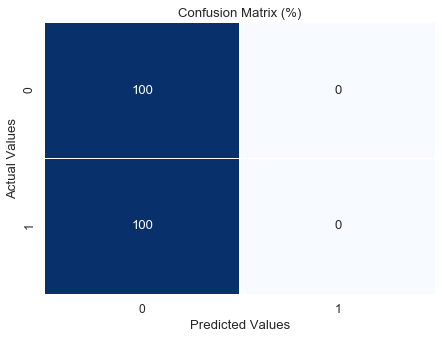

In [28]:
param1,F1=modeling(train1 , val1 , test1 ,im=True,y=50)

In [29]:
print(F1)

['GGI_r', 'GGI_l']


# Part 4 

In [30]:
healthy1=data_imb.loc[data_imb['class']==0]
unhealthy1=data_imb.loc[data_imb['class']==1]

the 4 first data
size_train :  584 ( 80.22 %)
size_test :  144 ( 19.78 %)


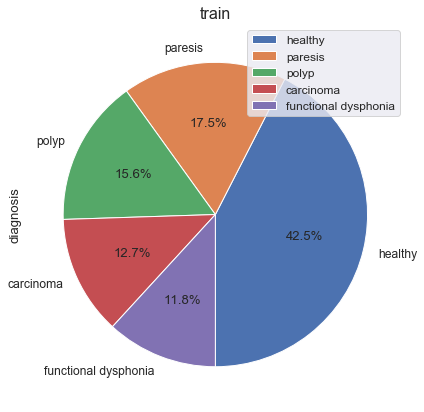

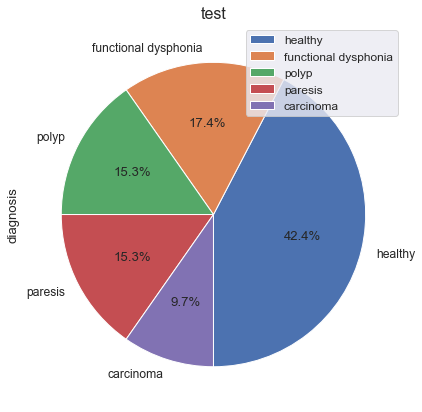

the final
size_train :  576 ( 79.121 %)
size_test :  152 ( 20.879 %)


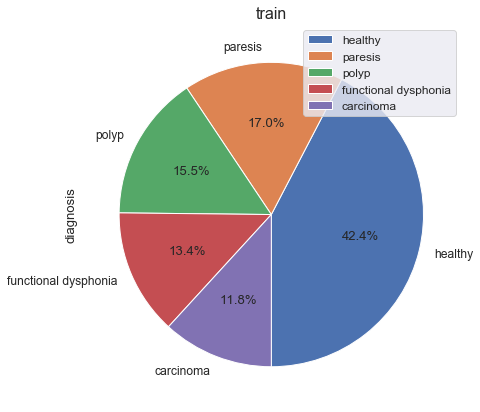

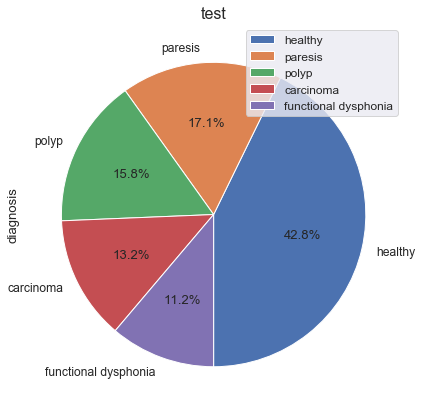

f1_score :  0.731
accuracy :  0.576
auc :  0.5
precision :  0.576
recall :  1.0


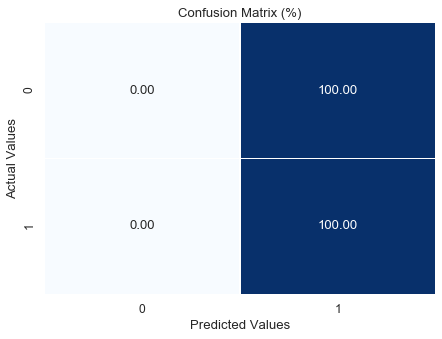

In [31]:
cross_val(healthy1,unhealthy1,param1,True,F1)

# Part 5

******************************** functional dysphonia ********************************
size_train :  281 ( 69.727 %)
size_train :  60 ( 14.888 %)
size_test :  62 ( 15.385 %)
*** Model :


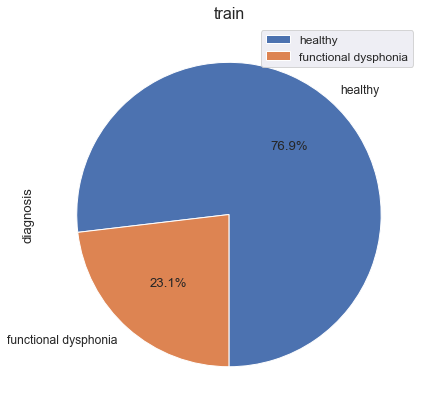

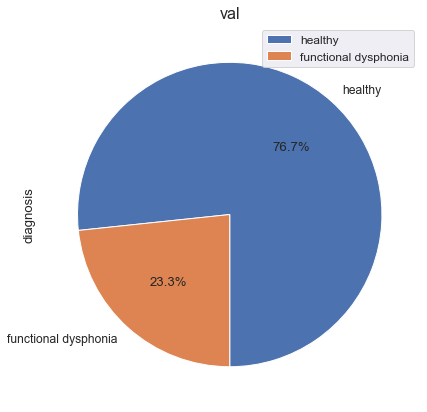

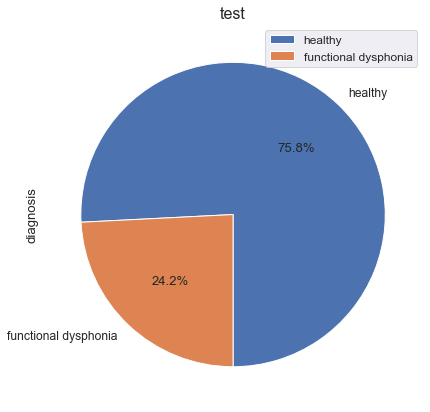

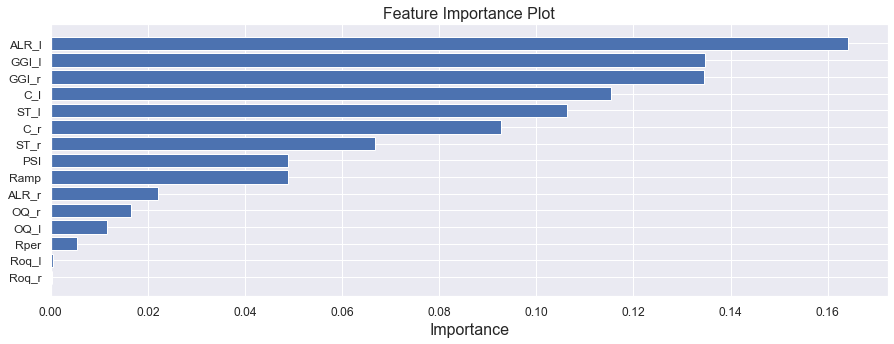

{'C': 0.0001, 'kernel': 'linear'}
f1_score :  0.0
accuracy :  0.758
auc :  0.5
precision :  0.0
recall :  0.0


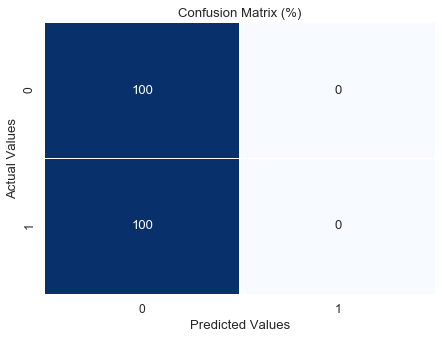

['GGI_r', 'GGI_l', 'ALR_l', 'C_r', 'C_l', 'ST_l']
***Cross_validation :
the 4 first data
size_train :  324 ( 80.397 %)
size_test :  79 ( 19.603 %)


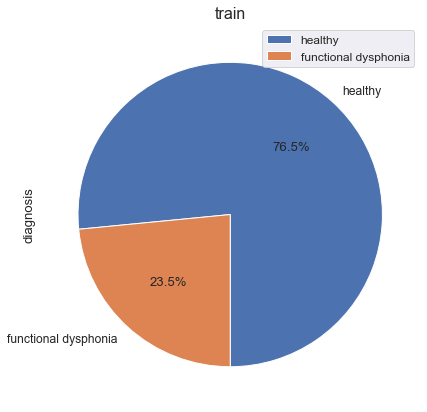

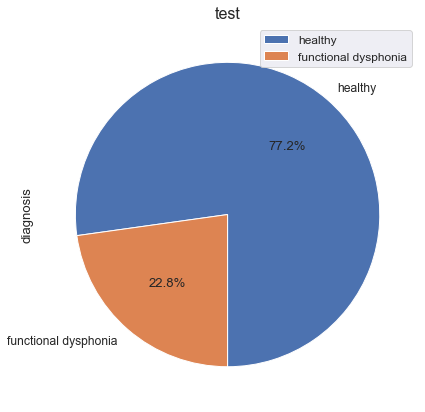

the final
size_train :  316 ( 78.412 %)
size_test :  87 ( 21.588 %)


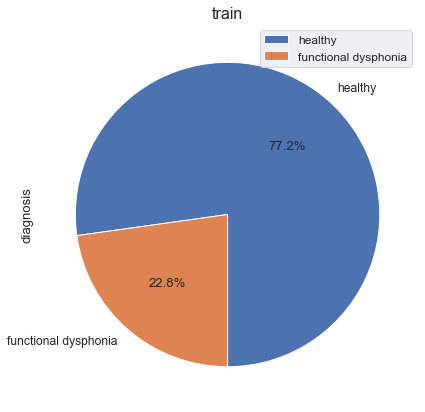

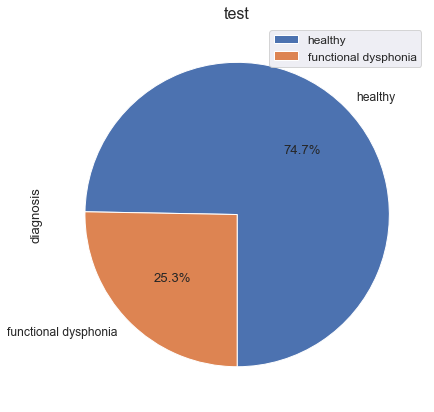

f1_score :  0.378
accuracy :  0.233
auc :  0.5
precision :  0.233
recall :  1.0


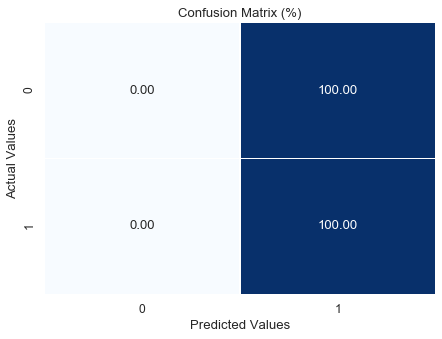

******************************** paresis ********************************
size_train :  302 ( 69.746 %)
size_train :  64 ( 14.781 %)
size_test :  67 ( 15.473 %)
*** Model :


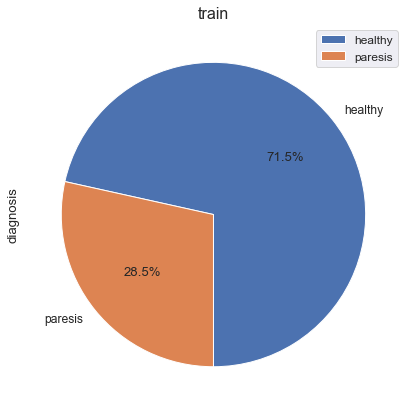

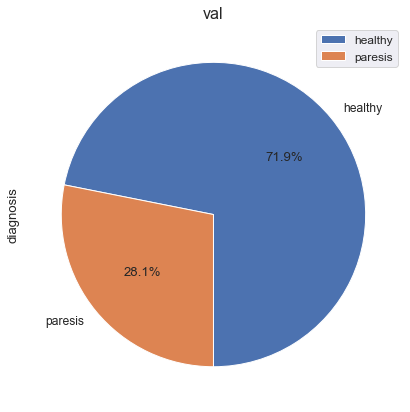

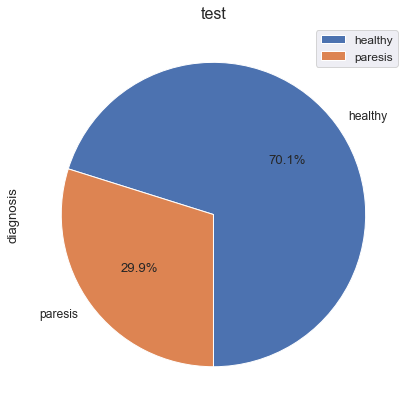

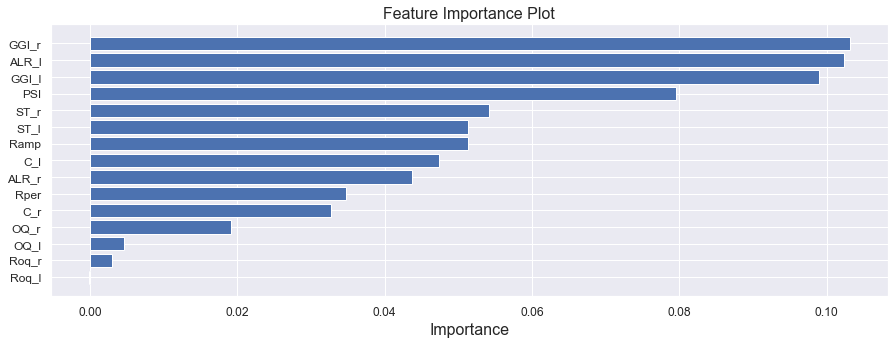

{'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}
f1_score :  0.46
accuracy :  0.299
auc :  0.5
precision :  0.299
recall :  1.0


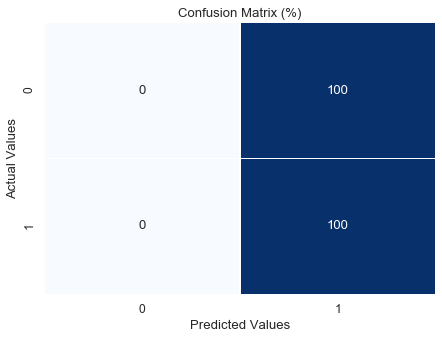

['PSI', 'GGI_r', 'GGI_l', 'ALR_l', 'ST_r']
***Cross_validation :
the 4 first data
size_train :  348 ( 80.37 %)
size_test :  85 ( 19.63 %)


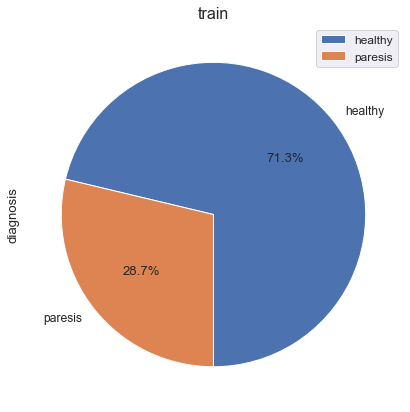

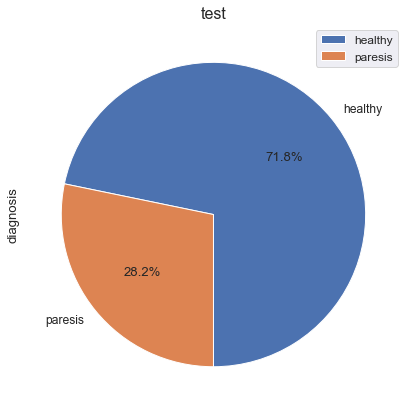

the final
size_train :  340 ( 78.522 %)
size_test :  93 ( 21.478 %)


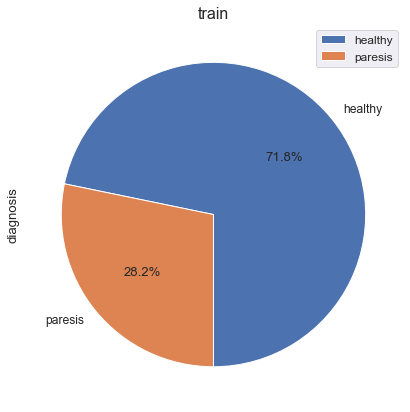

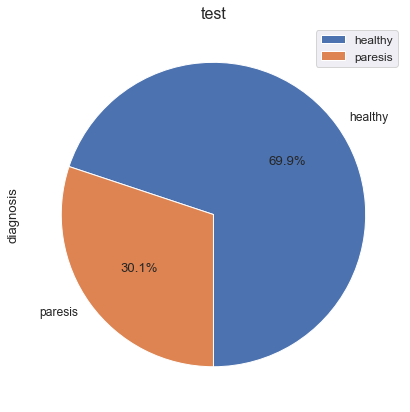

f1_score :  0.093
accuracy :  0.634
auc :  0.5
precision :  0.06
recall :  0.2


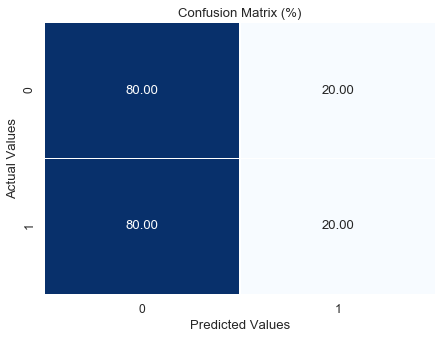

******************************** polyp ********************************
size_train :  295 ( 69.905 %)
size_train :  62 ( 14.692 %)
size_test :  65 ( 15.403 %)
*** Model :


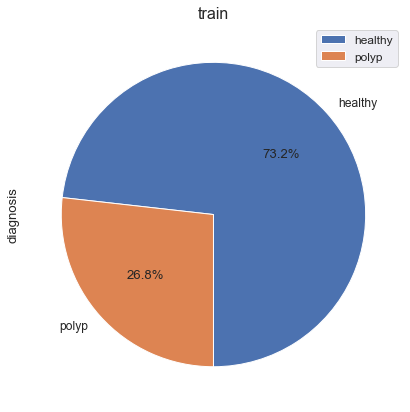

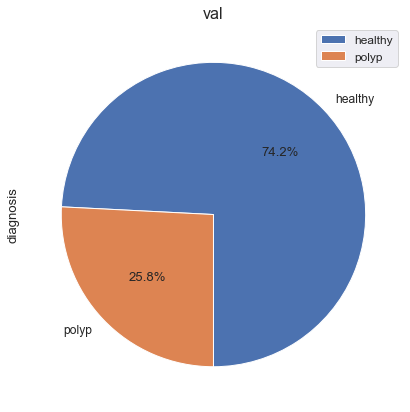

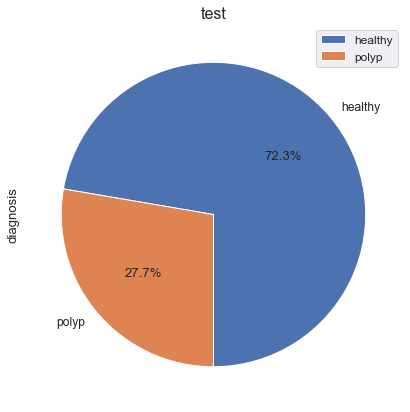

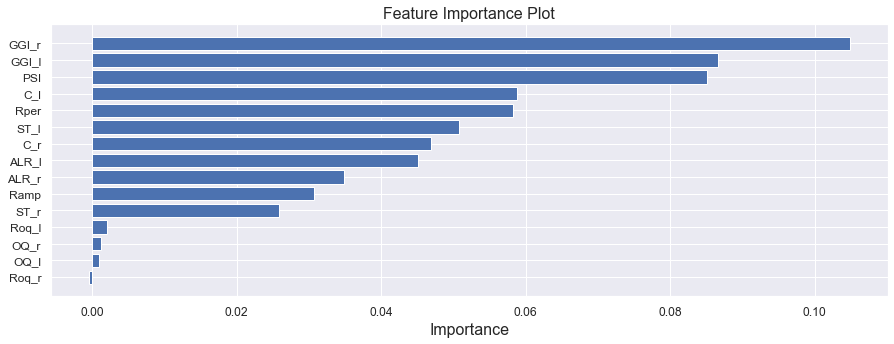

{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
f1_score :  0.0
accuracy :  0.723
auc :  0.5
precision :  0.0
recall :  0.0


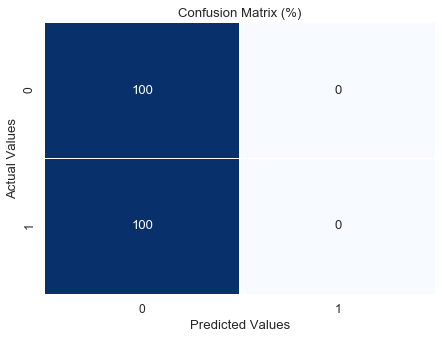

['Rper', 'PSI', 'GGI_r', 'GGI_l', 'C_l']
***Cross_validation :
the 4 first data
size_train :  339 ( 80.332 %)
size_test :  83 ( 19.668 %)


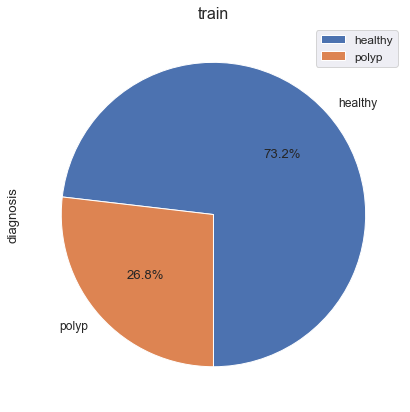

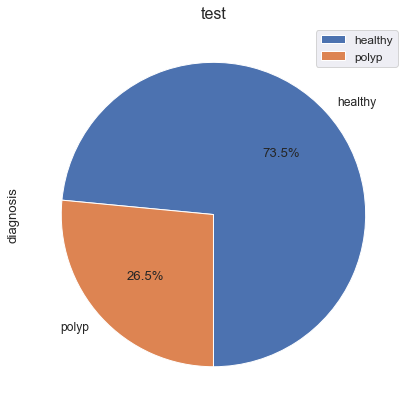

the final
size_train :  332 ( 78.673 %)
size_test :  90 ( 21.327 %)


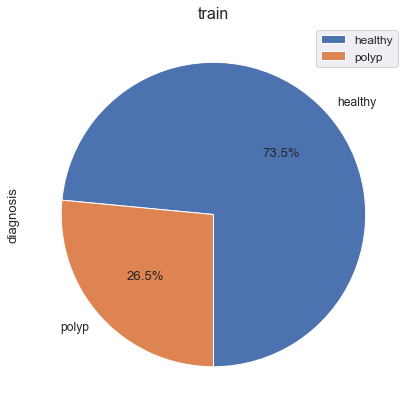

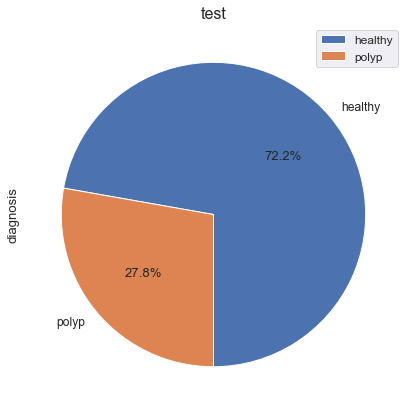

f1_score :  0.422
accuracy :  0.268
auc :  0.5
precision :  0.268
recall :  1.0


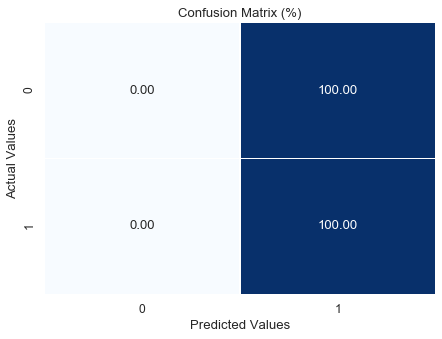

******************************** carcinoma ********************************
size_train :  277 ( 69.773 %)
size_train :  59 ( 14.861 %)
size_test :  61 ( 15.365 %)
*** Model :


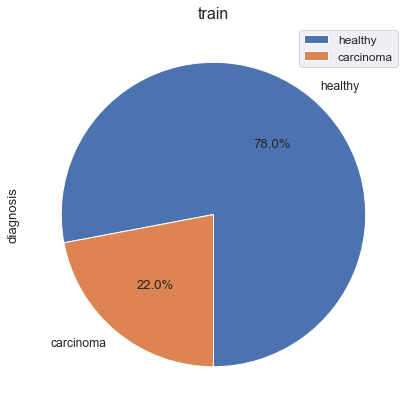

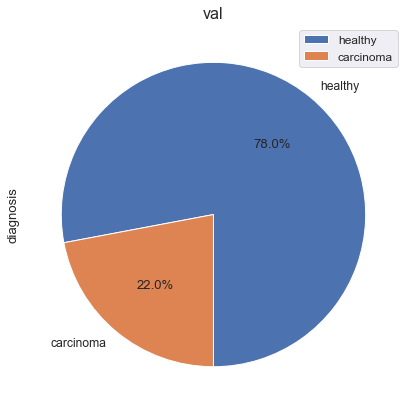

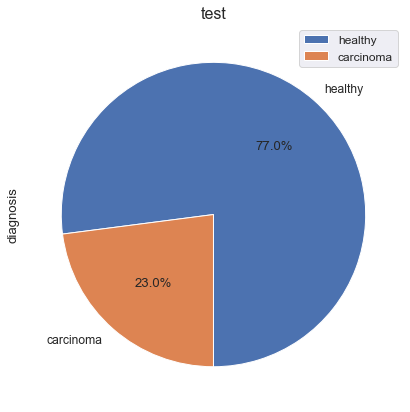

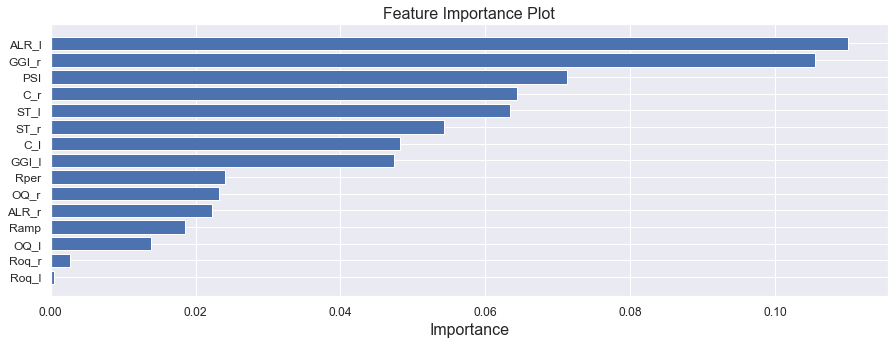

{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
f1_score :  0.373
accuracy :  0.23
auc :  0.5
precision :  0.23
recall :  1.0


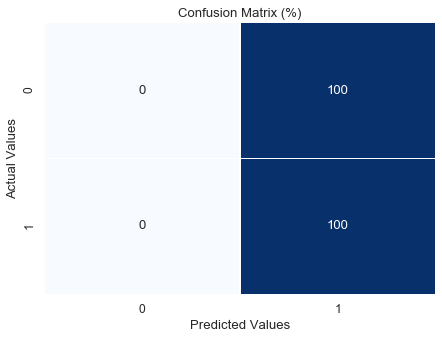

['PSI', 'GGI_r', 'ALR_l', 'C_r', 'ST_l']
***Cross_validation :
the 4 first data
size_train :  319 ( 80.353 %)
size_test :  78 ( 19.647 %)


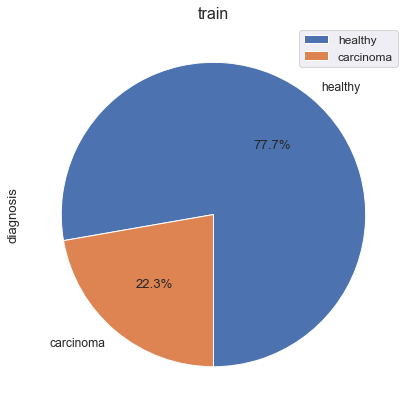

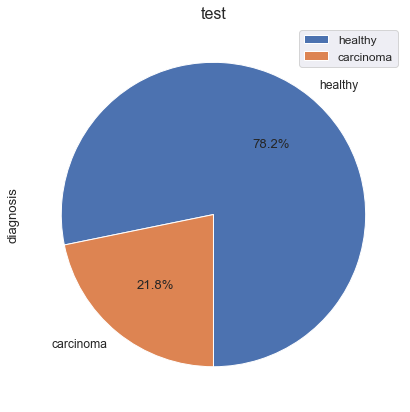

the final
size_train :  312 ( 78.589 %)
size_test :  85 ( 21.411 %)


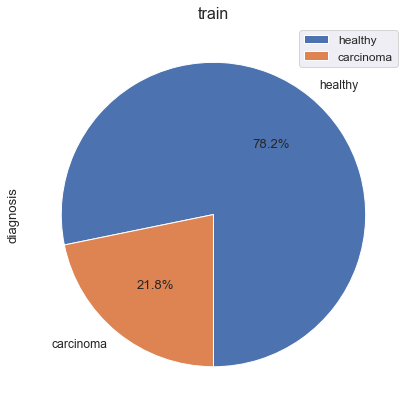

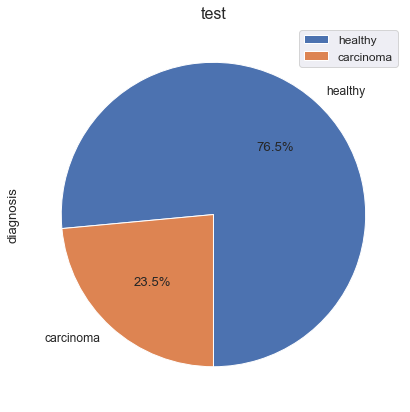

f1_score :  0.286
accuracy :  0.327
auc :  0.5
precision :  0.174
recall :  0.8


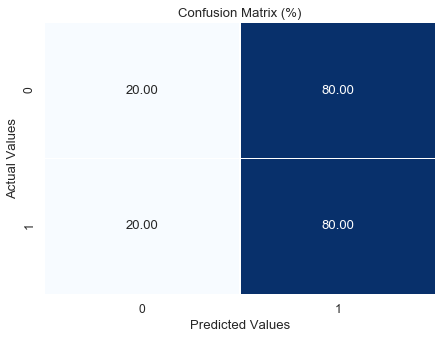

In [32]:
healthy2=data_imb.loc[data_imb['class']==0]
for x in ['functional dysphonia','paresis','polyp','carcinoma']:
    print(colored('******************************** '+x+' ********************************','red'))
    unhealthy2=data_imb.loc[data_imb['diagnosis']==x]
    train2, val2 ,test2 =divide(healthy2,unhealthy2)
    print(colored('*** Model :','blue'))
    param2,F2=modeling(train2 , val2 , test2 ,im=True,y=20 )
    print(F2)
    print(colored('***Cross_validation :','blue'))
    cross_val(healthy2,unhealthy2,param2,True,F2)

train.to_excel('C:/Users/USER/Desktop/stage ing/stage ing partie 3/train.xlsx')
val.to_excel('C:/Users/USER/Desktop/stage ing/stage ing partie 3/val.xlsx')
test.to_excel('C:/Users/USER/Desktop/stage ing/stage ing partie 3/test.xlsx')

train1.to_excel('C:/Users/USER/Desktop/stage ing/stage ing partie 3/train1.xlsx')
val1.to_excel('C:/Users/USER/Desktop/stage ing/stage ing partie 3/val1.xlsx')
test1.to_excel('C:/Users/USER/Desktop/stage ing/stage ing partie 3/test1.xlsx')

train2.to_excel('C:/Users/USER/Desktop/stage ing/stage ing partie 3/train2.xlsx')
val2.to_excel('C:/Users/USER/Desktop/stage ing/stage ing partie 3/val2.xlsx')
test2.to_excel('C:/Users/USER/Desktop/stage ing/stage ing partie 3/test2.xlsx')

healthy.to_excel('C:/Users/USER/Desktop/stage ing/stage ing partie 3/healthy.xlsx')
unhealthy.to_excel('C:/Users/USER/Desktop/stage ing/stage ing partie 3/unhealthy.xlsx')

healthy1.to_excel('C:/Users/USER/Desktop/stage ing/stage ing partie 3/healthy1.xlsx')
unhealthy1.to_excel('C:/Users/USER/Desktop/stage ing/stage ing partie 3/unhealthy1.xlsx')

healthy2.to_excel('C:/Users/USER/Desktop/stage ing/stage ing partie 3/healthy2.xlsx')
unhealthy2.to_excel('C:/Users/USER/Desktop/stage ing/stage ing partie 3/unhealthy2.xlsx')

# Part 6 

In [33]:
healthy3  =  new_dd.loc[new_dd['diagnosis']=='healthy']
healthy3 ['class'] = 0 # For healthy

unhealthy3 = new_dd.loc[new_dd['diagnosis']!='healthy']
unhealthy3 ['class'] = 1

unhealthy3.loc[unhealthy3.diagnosis=='paresis','class']=2 # For paresis disease
unhealthy3.loc[unhealthy3.diagnosis=='polyp','class']=3 # For polyp disease
unhealthy3.loc[unhealthy3.diagnosis=='carcinoma','class']=4 # For carcinoma disease
unhealthy3=shuffling(unhealthy3)

In [34]:
train3 , val3 , test3 = divide (healthy3 ,unhealthy3)

size_train :  509 ( 69.918 %)
size_train :  108 ( 14.835 %)
size_test :  111 ( 15.247 %)


train3.to_excel('C:/Users/USER/Desktop/stage ing/stage ing partie 3/train3.xlsx')
val3.to_excel('C:/Users/USER/Desktop/stage ing/stage ing partie 3/val3.xlsx')
test3.to_excel('C:/Users/USER/Desktop/stage ing/stage ing partie 3/test3.xlsx')

healthy3.to_excel('C:/Users/USER/Desktop/stage ing/stage ing partie 3/healthy3.xlsx')
unhealthy3.to_excel('C:/Users/USER/Desktop/stage ing/stage ing partie 3/unhealthy3.xlsx')

## Without Calibration

### OneVsOne

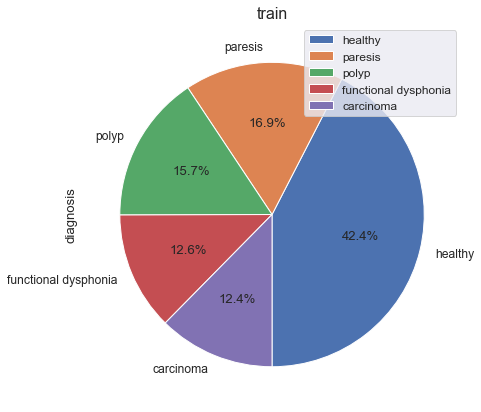

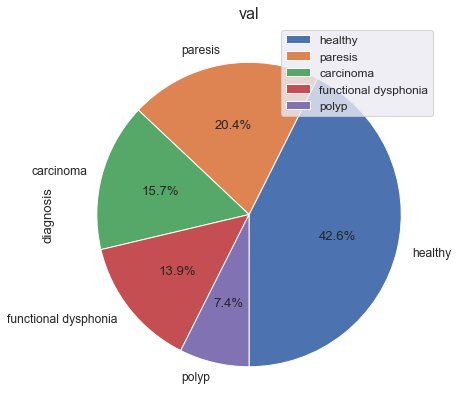

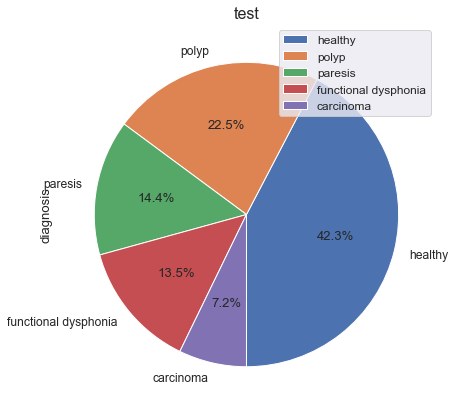

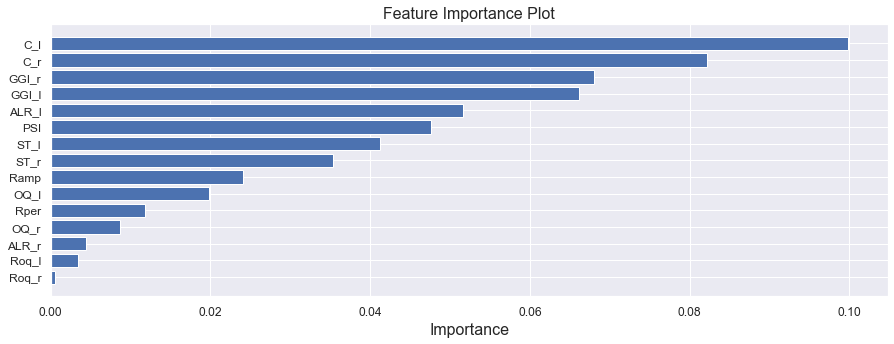

Model : SVC(C=25, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


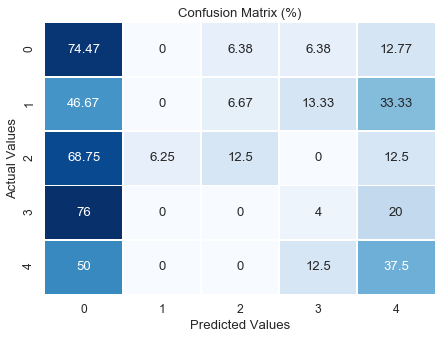

In [35]:
param3,F3=modeling1(train3 , val3 , test3 ,im=True ,m='ovo',y=50)

In [36]:
print(F3)

['GGI_r', 'GGI_l', 'ALR_l', 'C_r', 'C_l']


the 4 first data
size_train :  584 ( 80.22 %)
size_test :  144 ( 19.78 %)


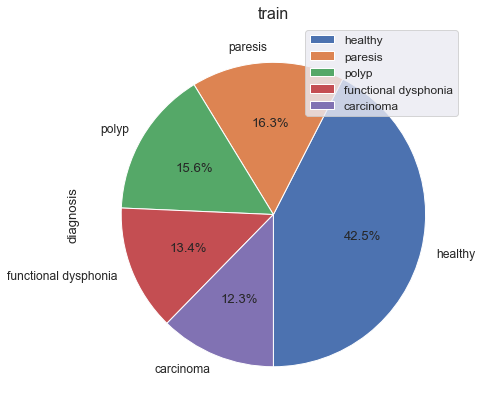

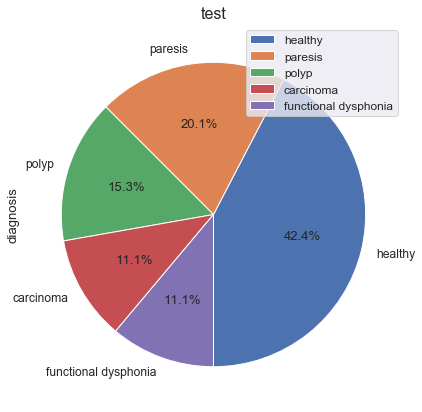

the final
size_train :  576 ( 79.121 %)
size_test :  152 ( 20.879 %)


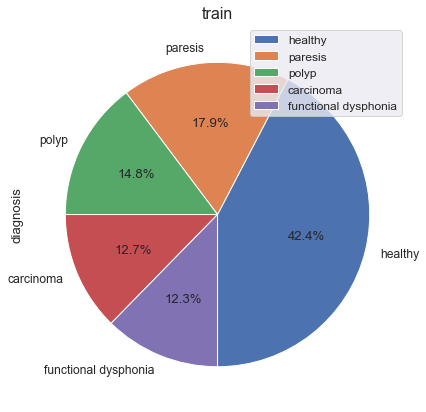

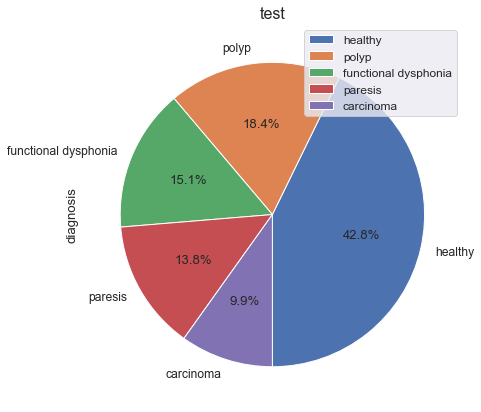

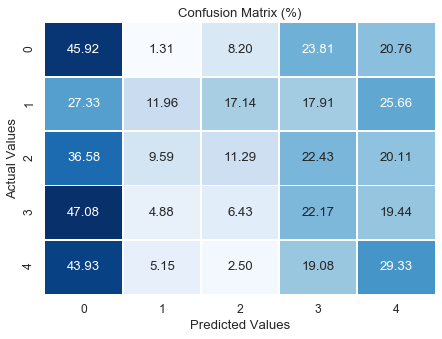

In [37]:
cross_val1(healthy3,unhealthy3,param3,True,'ovo',F3)

### OneVsRest

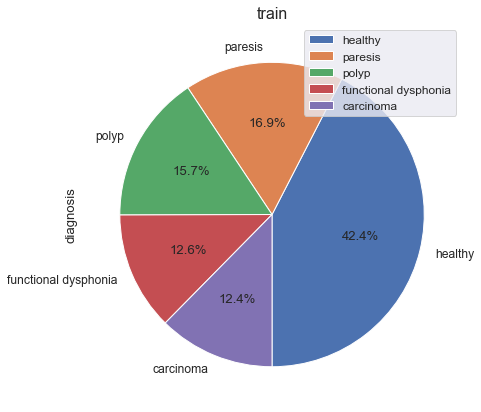

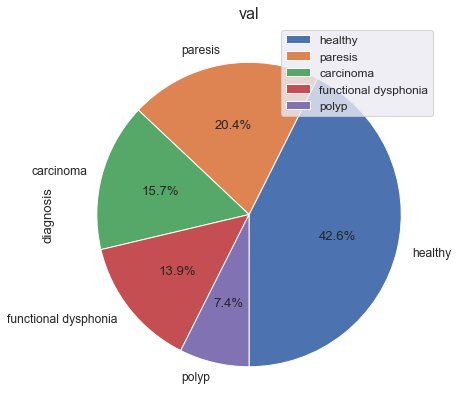

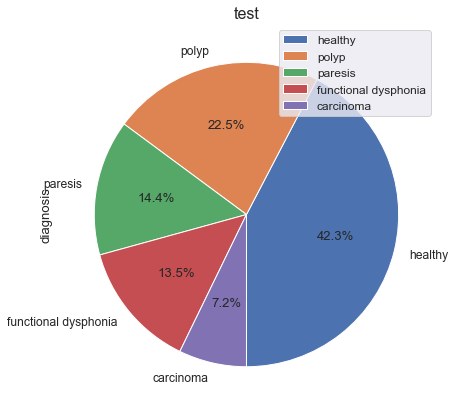

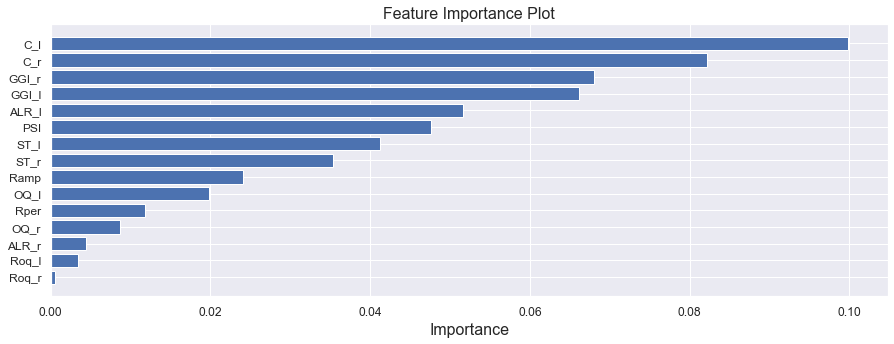

Model : SVC(C=25, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


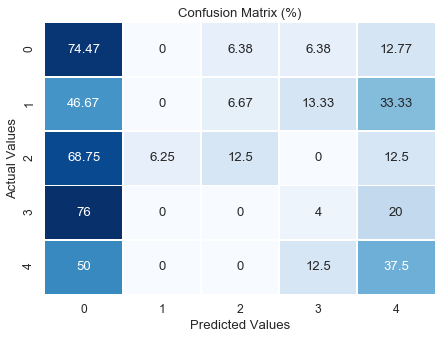

In [38]:
param4,F4 =modeling1(train3 , val3 , test3 ,im=True ,m='ovr',y=50)

In [39]:
print(F4)

['GGI_r', 'GGI_l', 'ALR_l', 'C_r', 'C_l']


the 4 first data
size_train :  584 ( 80.22 %)
size_test :  144 ( 19.78 %)


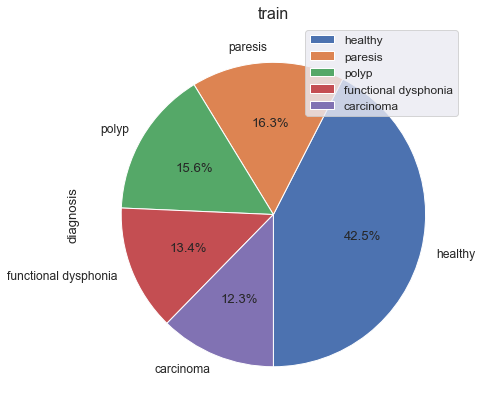

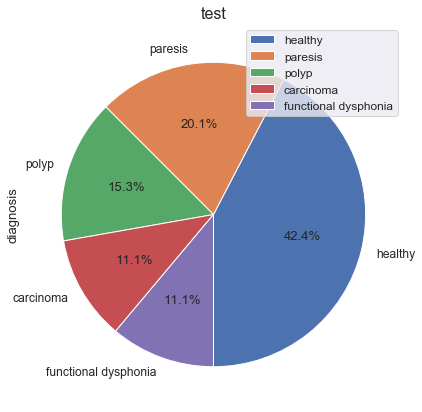

the final
size_train :  576 ( 79.121 %)
size_test :  152 ( 20.879 %)


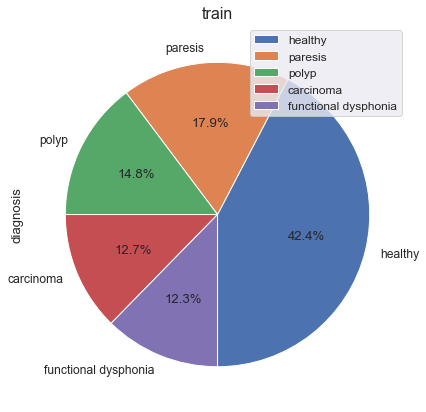

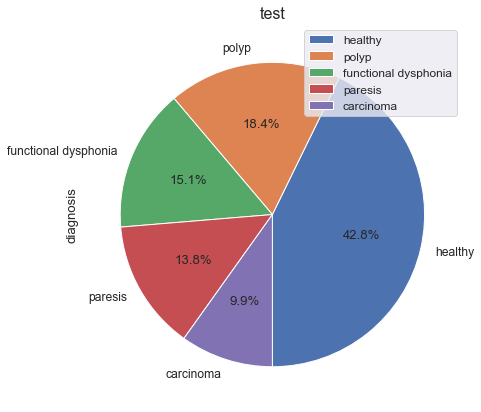

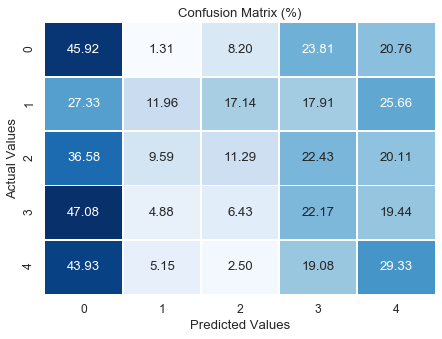

In [40]:
cross_val1(healthy3,unhealthy3,param4,True,'ovr',F4)

## With Calibration 

### OneVsRest

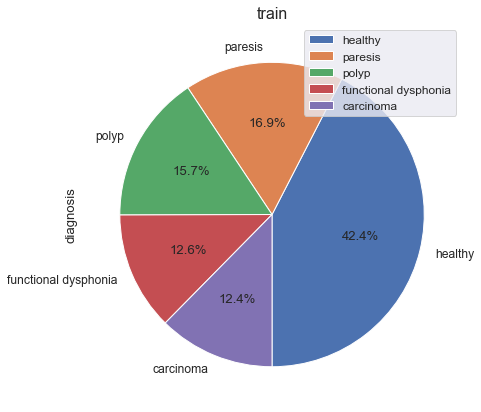

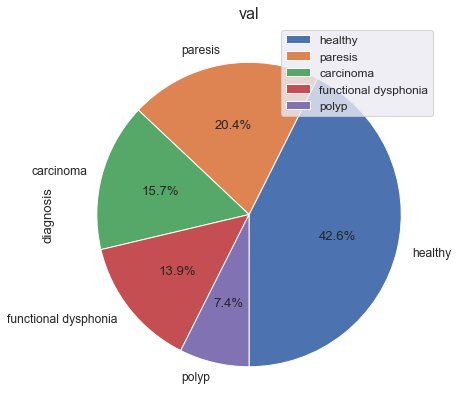

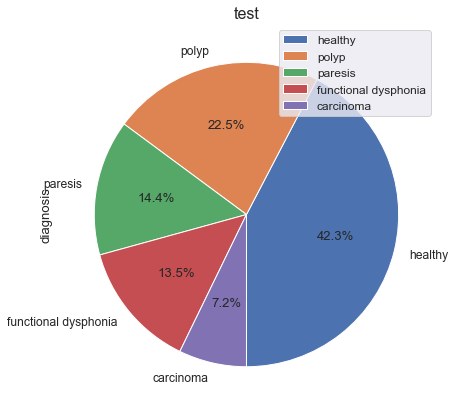

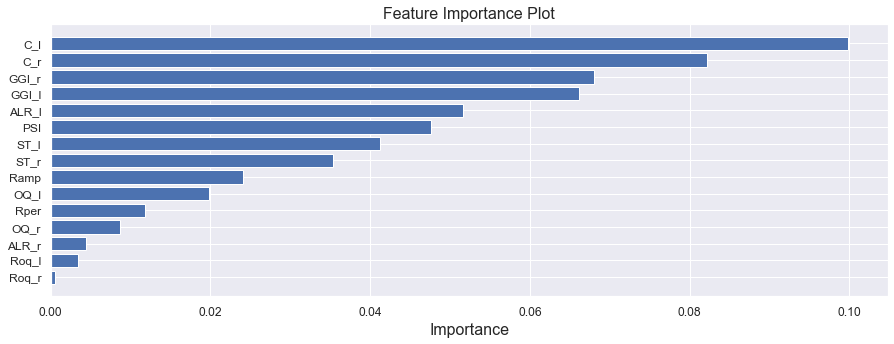

Model : CalibratedClassifierCV(base_estimator=SVC(C=25, break_ties=False,
                                          cache_size=200,
                                          class_weight='balanced', coef0=0.0,
                                          decision_function_shape='ovr',
                                          degree=3, gamma=0.001, kernel='rbf',
                                          max_iter=-1, probability=False,
                                          random_state=None, shrinking=True,
                                          tol=0.001, verbose=False),
                       cv=5, method='isotonic')


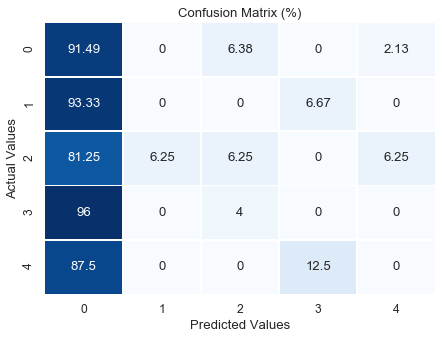

In [41]:
param5,F5=modeling2(train3 , val3 , test3 ,im=True ,m='ovr',c=5,method='isotonic',y=50)

In [42]:
print(F5)

['GGI_r', 'GGI_l', 'ALR_l', 'C_r', 'C_l']


the 4 first data
size_train :  584 ( 80.22 %)
size_test :  144 ( 19.78 %)


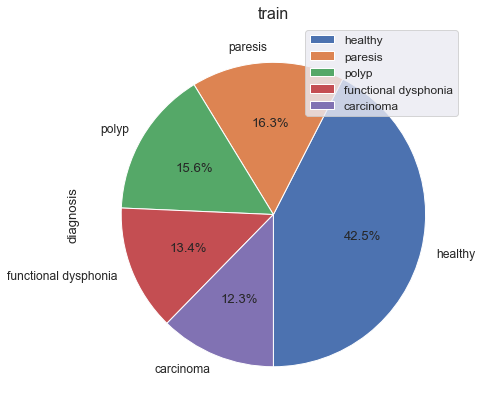

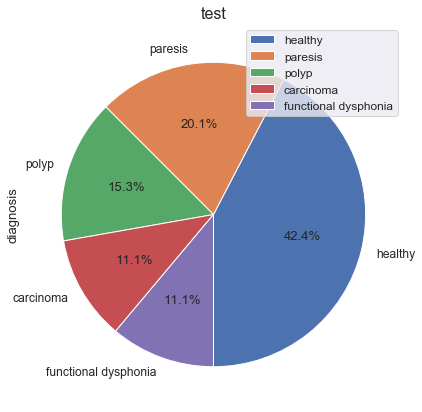

the final
size_train :  576 ( 79.121 %)
size_test :  152 ( 20.879 %)


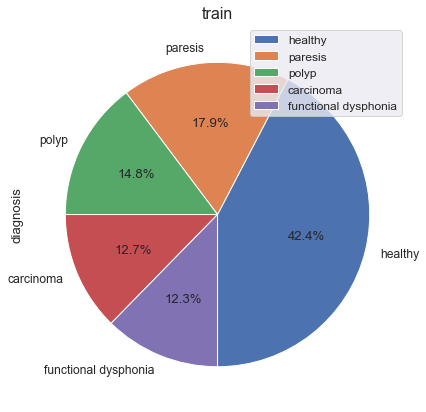

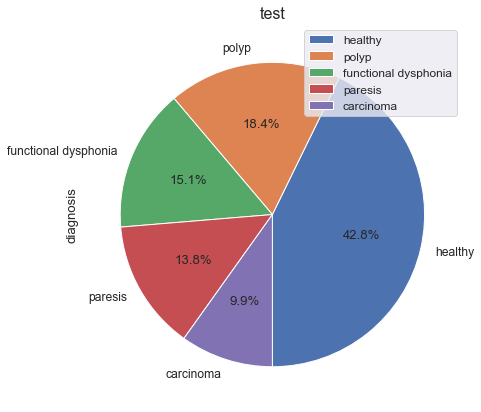

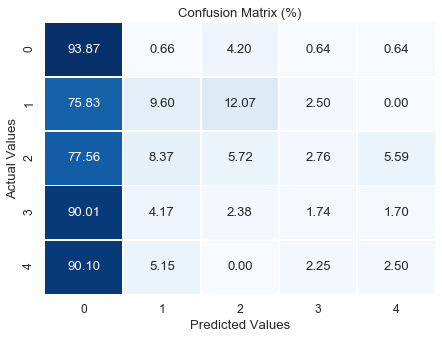

In [43]:
cross_val2(healthy3,unhealthy3,param5,True,'ovr',5,'isotonic',F5)